# Entropiecodierung
## 1 Informationsgehalt
### 1.1 Information der Wortlänge

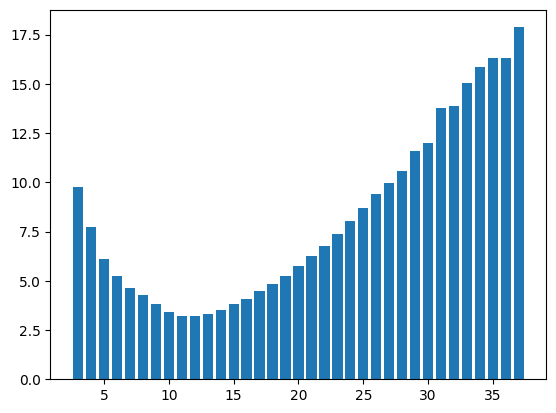

In [15]:
from math import log2
from collections import Counter
import matplotlib.pyplot as plt

words = open("wortliste.txt").readlines()

wordlen_count = Counter([len(line) for line in words])
word_dict = {
    length: log2(len(words) / count) for (length, count) in wordlen_count.items()
}

fig, ax = plt.subplots()
ax.bar(word_dict.keys(), word_dict.values())
plt.show()

### 1.2 Information der einzelnen Buchstaben

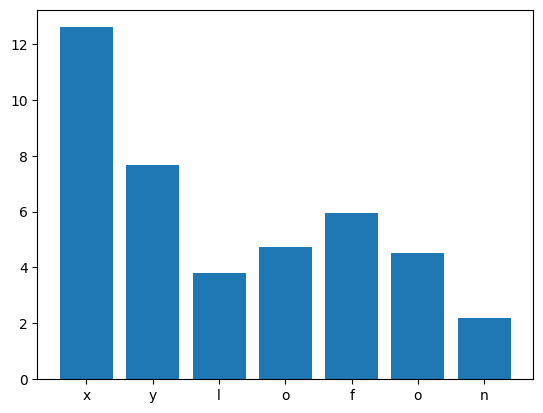

In [16]:
eight_letter_words = [word.lower() for word in words if len(word) == 8]

letters = ["x", "y", "l", "o", "f", "o", "n"]

counts = [
    len(list(filter(lambda x: x[i] == letters[i], eight_letter_words)))
    for i in range(len(letters))
]

information = [
    log2(len(eight_letter_words) / count) if count > 0 else 0 for count in counts
]

fig, ax = plt.subplots()
ax.bar(range(len(letters)), information)
ax.set_xticks(range(len(letters)))
ax.set_xticklabels(letters)
plt.show()

### 1.3 Von vorne nach hinten und von hinten nach vorne

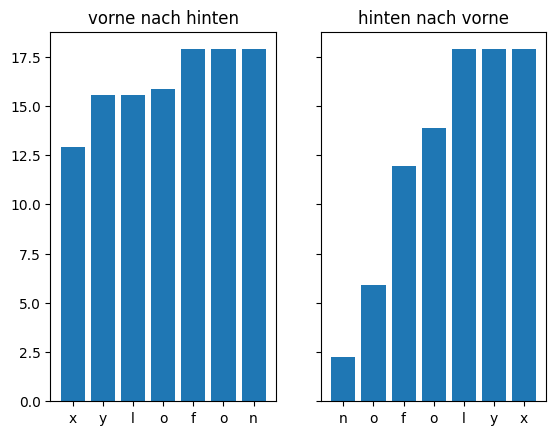

In [17]:
letters = "xylofon"

length = len(letters)

front_to_back = [0 for _ in range(length)]
back_to_front = [0 for _ in range(length)]

for i in range(length):
    matching_front = [
        word for word in words if word.strip().lower().startswith(letters[: i + 1])
    ]

    matching_back = [
        word for word in words if word.strip().lower().endswith(letters[-(i + 1) :])
    ]

    count_front = len(matching_front)
    count_back = len(matching_back)

    front_to_back[i] = log2(len(words) / count_front) if count_front > 0 else 0
    back_to_front[i] = log2(len(words) / count_back) if count_back > 0 else 0

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.bar(range(length), front_to_back)
ax1.set_title("vorne nach hinten")
ax1.set_xticks(range(length))
ax1.set_xticklabels(letters)

ax2.bar(range(length), back_to_front)
ax2.set_title("hinten nach vorne")
ax2.set_xticks(range(length))
ax2.set_xticklabels(letters[::-1])

plt.show()

## 2 Nachrichtenquelle

In [18]:
from typing import Dict


class LetterStat:
    """Class to keep track of stats for a certain letter"""

    def __init__(
        self, frequency: int, probability: float, information: float, entropy: float
    ):
        self.frequency = frequency
        self.probability = probability
        self.information = information
        self.entropy = entropy

    def __str__(self):
        return "\tFreq: {}\n\tProb: {}\n\tInfo: {}\n\tEntr: {}".format(
            self.frequency, self.probability, self.information, self.entropy
        )


class Source:
    """Class to calculate statistics to each letter for a word"""

    letter_stats: Dict[str, LetterStat]

    def __init__(self, word: str):
        frequencies = Counter(list(word.lower()))
        self.letter_stats = {
            char: LetterStat(
                count,
                count / len(word),
                log2(len(word) / count),
                (count / len(word)) * log2(len(word) / count),
            )
            for char, count in frequencies.items()
            if char.isalpha()
        }

    def print_stats(self):
        for char, stat in self.letter_stats.items():
            print("'", char, "':", stat, end="\n\n")

    def get_stats(self) -> list[tuple[str, int, int]]:
        items = []
        for char, item in self.letter_stats.items():
            items.append((char, item.frequency, item.information))
        return items

    def length(self) -> int:
        return len(self.letter_stats)


### 2.1 Test
Test mit dem Wort 'Hochschule'

In [19]:
hochschule = Source("Hochschule")
hochschule.print_stats()

' h ': 	Freq: 3
	Prob: 0.3
	Info: 1.7369655941662063
	Entr: 0.5210896782498619

' o ': 	Freq: 1
	Prob: 0.1
	Info: 3.321928094887362
	Entr: 0.33219280948873625

' c ': 	Freq: 2
	Prob: 0.2
	Info: 2.321928094887362
	Entr: 0.46438561897747244

' s ': 	Freq: 1
	Prob: 0.1
	Info: 3.321928094887362
	Entr: 0.33219280948873625

' u ': 	Freq: 1
	Prob: 0.1
	Info: 3.321928094887362
	Entr: 0.33219280948873625

' l ': 	Freq: 1
	Prob: 0.1
	Info: 3.321928094887362
	Entr: 0.33219280948873625

' e ': 	Freq: 1
	Prob: 0.1
	Info: 3.321928094887362
	Entr: 0.33219280948873625



### 2.2 RFC 2324

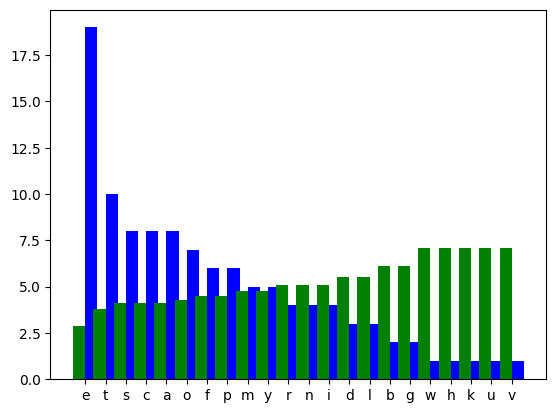

In [20]:
from operator import itemgetter

htcpcp = (
    "BREW\r\n"
    "Scheme: coffee\r\n"
    "Content-Type: message/coffeepot\r\n"
    "Accept-Additions: milk-type/Cream, syrup-type/Vanilla\r\n"
    "coffee-message-body=start\r\n"
)

htcpcp_source = Source(htcpcp)

stats = htcpcp_source.get_stats()
stats.sort(key=itemgetter(1), reverse=True)

ax = plt.subplot()
w = 0.3
ax.bar(
    [x + w for x in range(len(stats))],
    [x[1] for x in stats],
    width=2 * w,
    color="b",
    align="center",
)
ax.bar(
    [x - w for x in range(len(stats))],
    [x[2] for x in stats],
    width=2 * w,
    color="g",
    align="center",
)
ax.set_xticks(range(len(stats)))
ax.set_xticklabels([x[0] for x in stats])
plt.show()

## 3 Entropiecodierung
### 3.1 Codierungsvorschrift (Huffman)

In [21]:
from heapq import heappush, heappop


# --- Huffman coding ---


class HuffmanNode:
    def __init__(self, freq, symbol, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq


def huffman_coding(text: str) -> dict[str, str]:
    # Calculate frequency of each character
    frequency = Counter(text)

    # Create a priority queue (min-heap)
    heap = []
    for char, freq in frequency.items():
        heappush(heap, HuffmanNode(freq, char))

    while len(heap) > 1:
        # Pop the two nodes with the smallest frequency
        left = heappop(heap)
        right = heappop(heap)

        # Push the new node back into the heap
        heappush(
            heap,
            HuffmanNode(
                left.freq + right.freq, left.symbol + right.symbol, left, right
            ),
        )

    huffman_dict = {}

    # Generate Huffman codes
    def generate_codes(node: HuffmanNode, current_code: str) -> None:
        if node is None:
            return

        if node.left is None and node.right is None:
            huffman_dict[node.symbol] = current_code
            return

        generate_codes(node.left, current_code + "0")
        generate_codes(node.right, current_code + "1")

    root = heappop(heap)
    generate_codes(root, "")
    return huffman_dict

def from_huffman_dict(huffman_dict: dict[str, str], message: list[str]) -> str:
    reverse_huffman_dict = {v: k for k, v in huffman_dict.items()}
    return "".join(reverse_huffman_dict[m] for m in message)


# --- Shannon-Fano coding ---


class ShannonFanoNode:
    def __init__(self):
        self.sym = ""
        self.pro = 0.0
        self.code = ""

    def __lt__(self, other):
        return self.pro < other.pro


def _shannon_fano(low: int, high: int, nodes: list[ShannonFanoNode]) -> None:
    pack1 = 0
    pack2 = 0
    diff1 = 0
    diff2 = 0
    if (low + 1) == high or low == high or low > high:
        if low == high or low > high:
            return
        nodes[high].code += "0"
        nodes[low].code += "1"

        return
    else:
        for i in range(low, high):
            pack1 = pack1 + nodes[i].pro
        pack2 = pack2 + nodes[high].pro
        diff1 = abs(pack1 - pack2)
        j = 2
        while j != high - low + 1:
            k = high - j
            pack1 = pack2 = 0
            for i in range(low, k + 1):
                pack1 = pack1 + nodes[i].pro
            for i in range(high, k, -1):
                pack2 = pack2 + nodes[i].pro
            diff2 = abs(pack1 - pack2)
            if diff2 >= diff1:
                break
            diff1 = diff2
            j += 1
        k += 1
        for i in range(low, k + 1):
            nodes[i].code += "1"
        for i in range(k + 1, high + 1):
            nodes[i].code += "0"

        _shannon_fano(low, k, nodes)
        _shannon_fano(k + 1, high, nodes)


def shannon_fano(text: str) -> dict[str, str]:
    counter = Counter(text)

    nodes: list[ShannonFanoNode] = []
    N = len(counter)

    for char, freq in counter.items():
        node = ShannonFanoNode()
        node.sym = char
        node.pro = freq / len(text)
        nodes.append(node)

    nodes.sort()

    _shannon_fano(0, N - 1, nodes)

    shannon_fano_dict = {node.sym: node.code for node in nodes}

    return shannon_fano_dict

def from_shannon_fano(shannon_fano_dict: dict[str, str], message: list[str]) -> str:
    reverse_shannon_fano_dict = {v: k for k, v in shannon_fano_dict.items()}
    return "".join(reverse_shannon_fano_dict[m] for m in message)



#### 3.1.1 Test
Mit Beispielen aus der Vorlesung

In [22]:
examples = ["hochschule", "aaaaaaaaaaaabbbbbbcccccddddeeee"]

for example in examples:
    print("\nHuffman coding for:", example)
    huffman_dict = huffman_coding(example)
    print("Huffman codes:", huffman_dict)
    print(
        "L = {:1.3f}".format(
            sum(
                len(code)
                * len("".join(filter(lambda x: x == letter, example)))
                / len(example)
                for letter, code in huffman_dict.items()
            )
        )
    )
    print(
        "Decoded Huffman codes:",
        from_huffman_dict(huffman_dict, [huffman_dict[letter] for letter in example]),
    )

    print("\nShannon-Fano coding for:", example)
    shannon_fano_dict = shannon_fano(example)
    print("Shannon-Fano codes:", shannon_fano_dict)
    print(
        "L = {:1.3f}".format(
            sum(
                len(code)
                * len("".join(filter(lambda x: x == letter, example)))
                / len(example)
                for letter, code in shannon_fano_dict.items()
            )
        )
    )
    print(
        "Decoded Shannon-Fano codes:",
        from_shannon_fano(
            shannon_fano_dict, [shannon_fano_dict[letter] for letter in example]
        ),
    )


Huffman coding for: hochschule
Huffman codes: {'e': '000', 's': '001', 'o': '010', 'l': '011', 'u': '100', 'c': '101', 'h': '11'}
L = 2.700
Decoded Huffman codes: hochschule

Shannon-Fano coding for: hochschule
Shannon-Fano codes: {'o': '1111', 's': '1110', 'u': '110', 'l': '101', 'e': '100', 'c': '01', 'h': '00'}
L = 2.700
Decoded Shannon-Fano codes: hochschule

Huffman coding for: aaaaaaaaaaaabbbbbbcccccddddeeee
Huffman codes: {'a': '0', 'd': '100', 'e': '101', 'c': '110', 'b': '111'}
L = 2.226
Decoded Huffman codes: aaaaaaaaaaaabbbbbbcccccddddeeee

Shannon-Fano coding for: aaaaaaaaaaaabbbbbbcccccddddeeee
Shannon-Fano codes: {'d': '111', 'e': '110', 'c': '10', 'b': '01', 'a': '00'}
L = 2.258
Decoded Shannon-Fano codes: aaaaaaaaaaaabbbbbbcccccddddeeee


In [23]:
from typing import Callable


class Coding:
    def __init__(self, text: str, coding: Callable[[str], dict[str, str]]):
        self.text = text
        self.coding = coding
        self.encode_dict = coding(text)
        self.decode_dict = {v: k for k, v in self.encode_dict.items()}

    def encode(self, word: str) -> tuple[str, int, int]:
        """`encode` liefert den Binärcode, die mittlere Anzahl der Bits und die daraus resultierende Redundanz"""
        code = "".join([self.encode_dict[letter] for letter in word])
        L = sum(
            len(code)
            * len("".join(filter(lambda x: x == letter, self.text)))
            / len(self.text)
            for letter, code in self.encode_dict.items()
        )
        redundancy = L - log2(len(self.text))
        return code, L, redundancy

    def decode(self, code: str) -> str:
        """`decode` liefert den ursprünglichen Text zurück"""
        decoded = ""
        current_code = ""
        for bit in code:
            current_code += bit
            if current_code in self.decode_dict:
                decoded += self.decode_dict[current_code]
                current_code = ""
        return decoded

## 4 Vergleich
### 4.1 Arithmetische Codierung
### 4.2 RFC 2324

In [24]:
from arithmetic_compressor import AECompressor
from arithmetic_compressor.models import StaticModel

model = StaticModel({char: freq for (char, freq, _info) in htcpcp_source.get_stats()})
coder = AECompressor(model)

data = [letter.lower() for letter in htcpcp if letter.isalpha()]
N = len(data)

print(f"\nTo compress: '{data}' (len={len(data)})")

encoded = coder.compress(data)

ratio = (1 - len(encoded) / (len(data) * 8)) * 100
print(f"Compressed: {encoded} (len={len(encoded)})")
print(f"Compression ratio: {ratio}% (Assuming 8 bits per char)")


To compress: '['b', 'r', 'e', 'w', 's', 'c', 'h', 'e', 'm', 'e', 'c', 'o', 'f', 'f', 'e', 'e', 'c', 'o', 'n', 't', 'e', 'n', 't', 't', 'y', 'p', 'e', 'm', 'e', 's', 's', 'a', 'g', 'e', 'c', 'o', 'f', 'f', 'e', 'e', 'p', 'o', 't', 'a', 'c', 'c', 'e', 'p', 't', 'a', 'd', 'd', 'i', 't', 'i', 'o', 'n', 's', 'm', 'i', 'l', 'k', 't', 'y', 'p', 'e', 'c', 'r', 'e', 'a', 'm', 's', 'y', 'r', 'u', 'p', 't', 'y', 'p', 'e', 'v', 'a', 'n', 'i', 'l', 'l', 'a', 'c', 'o', 'f', 'f', 'e', 'e', 'm', 'e', 's', 's', 'a', 'g', 'e', 'b', 'o', 'd', 'y', 's', 't', 'a', 'r', 't']' (len=109)
Compressed: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1

### 4.3 Zufällige Nachrichten aus RFC 2324

Mittlere Länge Huffman: 4088.0
Mittlere Länge Shannon-Fano: 4115.8
Mittlere Länge arithmetisch: 4026.3


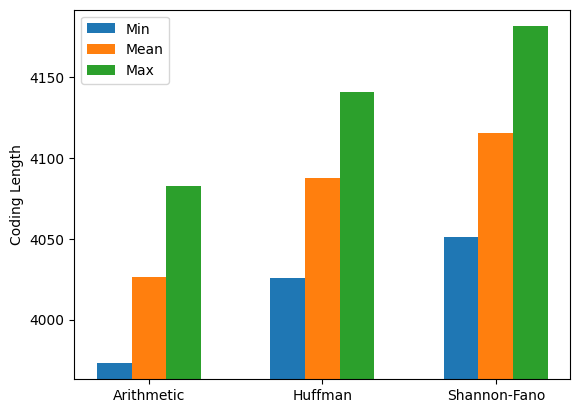

In [25]:
from random import choices


def generate_random_test(text, num):
    return "".join(choices(text, k=num))


sanitized_htcpcp = "".join(filter(lambda x: x.isalpha(), htcpcp.lower()))


coding_lengths_entropy_huffman = []
coding_lengths_entropy_shannon = []
coding_lengths_arithmetic = []

entropycoding_huffman = Coding(sanitized_htcpcp, huffman_coding)
entropycoding_shannon = Coding(sanitized_htcpcp, shannon_fano)


for _ in range(10):
    random_text = generate_random_test(sanitized_htcpcp, 1000)
    # Huffman
    code, _, _ = entropycoding_huffman.encode(random_text)
    coding_lengths_entropy_huffman.append(len(code))
    # Shannon
    code, _, _ = entropycoding_shannon.encode(random_text)
    coding_lengths_entropy_shannon.append(len(code))
    # Arithmetic
    model = StaticModel(
        {char: freq for (char, freq, _info) in Source(random_text).get_stats()}
    )
    coder = AECompressor(model)
    coding_lengths_arithmetic.append(len(coder.compress(random_text)))


# Huffman
print(
    "Mittlere Länge Huffman:",
    sum(coding_lengths_entropy_huffman) / len(coding_lengths_entropy_huffman),
)
# Shannon
print(
    "Mittlere Länge Shannon-Fano:",
    sum(coding_lengths_entropy_shannon) / len(coding_lengths_entropy_shannon),
)
# Arithmetic
print(
    "Mittlere Länge arithmetisch:",
    sum(coding_lengths_arithmetic) / len(coding_lengths_arithmetic),
)


# Calculate min, mean, and max for each encoding method
huffman_stats = (
    min(coding_lengths_entropy_huffman),
    sum(coding_lengths_entropy_huffman) / len(coding_lengths_entropy_huffman),
    max(coding_lengths_entropy_huffman),
)
shannon_stats = (
    min(coding_lengths_entropy_shannon),
    sum(coding_lengths_entropy_shannon) / len(coding_lengths_entropy_shannon),
    max(coding_lengths_entropy_shannon),
)
arithmetic_stats = (
    min(coding_lengths_arithmetic),
    sum(coding_lengths_arithmetic) / len(coding_lengths_arithmetic),
    max(coding_lengths_arithmetic),
)

# Plot
fig, ax = plt.subplots()
x_labels = ["Arithmetic", "Huffman", "Shannon-Fano"]
x_positions = range(len(x_labels))

# Plot bars for min, mean, and max
ax.bar(
    x_positions,
    [arithmetic_stats[0], huffman_stats[0], shannon_stats[0]],
    width=0.2,
    label="Min",
    align="center",
)
ax.bar(
    [x + 0.2 for x in x_positions],
    [arithmetic_stats[1], huffman_stats[1], shannon_stats[1]],
    width=0.2,
    label="Mean",
    align="center",
)
ax.bar(
    [x + 0.4 for x in x_positions],
    [arithmetic_stats[2], huffman_stats[2], shannon_stats[2]],
    width=0.2,
    label="Max",
    align="center",
)

min_value = min(huffman_stats[0], shannon_stats[0], arithmetic_stats[0])
max_value = max(huffman_stats[2], shannon_stats[2], arithmetic_stats[2])
ax.set_ylim([min_value - 10, max_value + 10])  # Start slightly below the minimum value


ax.set_xticks([x + 0.2 for x in x_positions])
ax.set_xticklabels(x_labels)
ax.set_ylabel("Coding Length")
ax.legend()
plt.show()